In [1]:
import autograd.numpy as np
import autograd
from numpy import random as rdm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats

## Diffusion Monte Carlo (DMC)

Diffusion Monte Carlo is a creative QMC method with a stronger reliance on Monte Carlo methods than VMC. The basic idea is as follows: if you rewrite the Schrodinger equation with imaginary time $t = i\tau$ and subtract out the ground-state energy $E_0$, you get: $$\hbar \frac{\partial}{\partial \tau} \psi = \left(-\frac{\hbar^2}{2m}\nabla^2 + V(x)-E_0\right) \psi$$

This can be broken into two parts: a diffusion equation (the laplacian term) whose motion is shaped by a background potential (the $V(x)-E_0$ term). Additionally, if we're looking at energy eigenstates $\psi_n$ with energy $E_n$, this has the following property:

$$\psi_n \propto \exp(-(E_n-E_0)\tau)$$

*Note, a factor of $hbar$ is dropped as we're setting it to 1 for computational ease.*

So any arbitrary $\psi = \sum \psi_n$ (since the energy eigenbasis is complete) will decay away until the only component left is $\psi_0$. Since we don't know $E_0$, we'll instead subtract a guess $E_{trial}$. As we evolve forward in imaginary time, we'll adjust this $E_{trial}$ according to the following logic -- if the size of the wave function is _growing_, that implies the trial energy is higher than $E_0$, and if it's _shrinking_, the trial energy is too low. It will become clear what this means as I lay out the algorithm. 

In physical space, we return to the interpretation that this is a modified diffusion equation which can be modeled by a random walk:

0. Start with an ensemble of points (called 'walkers') sampled from a trial wave function. 
1. Let each point $R_0$ take a random step to $R_f$, just like in the Metropolis MCMC algorithm. But now, instead of using the Metropolis acceptance probability, we use a path-integral inspired approach to 'branch' the wave function
2. Path integral/Green's function calculation: calculate the Green's function factor $$G(R_f|R_0) = e^(-(\frac{1}{2}(E_l(R_0)+E_l(R_f) - E_{trial})d\tau)$$ Where $E_l$ is the same local energy as before, and $d\tau$ is a parameterization of the time step. One hard part is the calculation of $E_l$ -- ideally, the kinetic energy is the path-integral kinetic energy $(R_0-R_f)^2/(2m d\tau^2)$, but I'm unable to get this to work. Instead, I calculate it as before using a trial wave function, which I update after each time step to be the square root of a histogram of the new ensemble of walkers. For a detailed derivation see [this paper](https://arxiv.org/abs/physics/9702023).
3. This Green's function factor is the weight, acting analagously to the weight $W$ in the MCMC algorithm. This time, though, instead of simply rejecting the move with probability $1-G$, we delete the walker completely, thereby reducing the number of points in our ensemble. If $G$ is greater than 1, though, we duplicate the walker, creating int($G$ + a random number between 0 and 1) new walkers at that point. This approximates the background potential's influence.
4. If the total number of walkers increases, lower $E_{trial}$. If it decreases, do the opposite. This is encapsulated by setting $E_{trial}$ to the average local energy of the walkers - $\alpha\log(M/M_0)$, where $M$ is the current number of walkers and $M_0$ is some target, usually the initial number.

We'll do this on the simple, analytically solvable harmonic oscillator, inspired by [this introduction](https://www.huy.dev/Terrel-thesis.pdf), though I couldn't get their exact implementation to work. This is especially nice because we can start with a trial wave function that's a superposition of energy eigenstates and watch as the higher energy states decay away. First, all the functions we need are defined.

Below is the algorithm to sample initial wave-function, same as before but optimized for 1D 

In [2]:
def step(A, f, n, i, base_dim=1): #A=origin, f=prob distribution, i=recursion tracker
    """
    
    
    """
    B = np.zeros(A.shape)
    B += A
    B[n] += 1*stats.norm.rvs(size=(base_dim)) #new location after step
    acc = rdm.rand() #threshold required to accept sample
    ACC = min(1, (f(B)/f(A))) #Metropolis acceptance probability
    if (acc <= ACC or i>= 10):
        return B
    else:
        return step(A, f, n, i+1, base_dim=base_dim)
    
window = 15
equilib_time = 1000

def sample(f, M, N, orig_dim=1):
    """
    This function samples a probability distribution using Metropolis
    Markov Chain Monte Carlo. 
    
    Args:
        f: probability distribution
        M: number of samples
        N: number of particles

    """
    
    #start with basic sample
    samples = 2*window*(rdm.rand(1, N, orig_dim)-0.5)
    
    #equilibration phase
    for m in range(equilib_time):
        for n in range(N):
            samples[0] = step(samples[0], f, n, 0, base_dim= orig_dim )
    
    #accumulation phase
    integral = 0
    
    for m in range(1, M):
        samples = np.append(samples, [samples[m-1]], axis=0)
        for n in range(N):
            samples[m] = step(samples[m], f, n, 0, base_dim = orig_dim)
    
    return samples


Energy functions, also optimized for 1D

In [3]:
def T(R, psi, m=1, hbar=1): #kinetic energy of psi
    
    grad_psi = autograd.grad(psi) #first derivative
    
    laplace_psi = autograd.grad(grad_psi) #second derivative
    
    return - np.sum((hbar**2 / 2*m) * laplace_psi(R))



def E_local(R, V, psi): #Local energy, as before
    return (T(R, psi) / (psi(R)+0.01)) + V(R)


def E_ave(samples, V, psi): #Average energy of an ensemble of walkers
    E=0
    for X in samples:
        E+= 1/samples.shape[0] * E_local(X, V, psi)
    return E


These are all the functions we'll need: _Green's function_, _move_, _branch_, and _analytical approximation_.

In [4]:
def greens_func(X0, Xf, V, psi, E_trial, dt=0.1):
    """
    Calculates the Green's function as described above
    
    X0, Xf: walker and its updated position
    V, psi, E_trial: potential, wave function, and trial energy
    dt parameterizes time step
    
    """
    E_l0 = E_local(X0, V, psi)
    E_lf = E_local(Xf, V, psi) 
    
    return np.e**(-(1/2 * (E_l0 + E_lf) - E_trial)*dt)


def move(walker, psi, V, E_trial, dt=0.1, i=0):
    """
    Moves walker to a new position, returns branched array of 
    walkers at that position
    
    """
    #Moves walker
    new_walker = np.zeros(walker.shape)
    new_walker += walker
    new_walker += dt*stats.norm.rvs(size=walker.shape)
    
    #Branches walker
    return branch(new_walker, walker, V, psi, E_trial)

def branch(new_walker, walker, V, psi, E_trial, dt=0.1):
    
    """
    Calculates the branching number for a given move, and returns
    a branched array of walkers at that position
    
    new_walker: walker after move
    walker: walker previous to move
    
    """
    
    #Calculates branching numbers
    branch_number = greens_func(walker, new_walker, V, psi, E_trial, dt=dt)
    branch_number += rdm.rand()
    branch_number = int(branch_number)
    
    #initializes branched array
    branched_walkers = np.array([[[]]])
    
    #Fills array with branching number walkers
    for i in range(min(branch_number,3)):
        branched_walkers = np.append(branched_walkers, new_walker)
    
    return branched_walkers


def analyitcally_approximate(vals):
    """
    Returns an updated wave function of the form described 
    below, approximated from a histogram of walker positions
    
    """
    
    #Gets histogram
    hist, x_vals = np.histogram(np.squeeze(vals), bins=20)
    x_vals = x_vals[:hist.shape[0]] #so shapes match
    
    #Defines a fit function based of oscillator wave function^2
    def osc_fit(X, A, b, c):
        return (A*(1 + b * X + c * (2*X**2 -1))*np.e**(- X**2/2))**2
    
    #Gets parameters of oscillator fit in array 'a'
    #Guess is based off experience to prevent strange oscillation
    #at beginning, but does not affect results
    a, covariance = curve_fit(osc_fit, x_vals, hist, p0=[50,0.5,0.5])
    
    #Defines oscillator wave function based off 'a'
    def return_function(X):
        return (1 + a[1]*X + a[2]*(2*X**2 -1))*np.e**(-X**2/2)
    
    print(f'Coefficient values: a={a[1]}, b={a[2]}')
    
    return return_function, a[1], a[2]



In [5]:
def DMC(V, M0, psi0, iterations=50, alpha=0.2, dt=0.1):
    """
    Controlles whole DMC process.
    
    V: potential
    M0: initial number of walkers
    psi0: initial wave function guess
    iterations: max number of iterations allowed
    alpha: coefficient controlling change of E_trial
    dt: change in imaginary time per time step
    
    returns:
    
    final energy E_trial
    ensemble of walkers
    array of energies after each iteration
    array of walker-numbers after each iteration
    bs and cs: arrays of coefficients of higher harmonic states
        after each iteration, from analytically_approximate function
    
    """
    
    ##Initialize walkers
    def psi0_mod_squared(X):
        return np.sum(psi0(X)**2)
    walkers = sample(psi0_mod_squared, M0, 1, orig_dim=1)
    
    #initialize energy
    E_trial = E_ave(walkers, V, psi0)
    
    #Initializing tracking arrays
    Energies = np.array([E_trial])
    bs = np.zeros(iterations)
    cs = np.zeros(iterations)
    Ms = np.zeros(iterations)
    Ms[0] = M0
    
    #Begin walking!
    for iteration in range(1, iterations):
        
        #Update walkers
        new_walkers = np.array([[[]]])
        
        for walker in walkers:
            #move the walker
            new_walker = move(walker, psi0, V, E_trial, dt=dt)
            
            new_walkers = np.append(new_walkers, new_walker)
        
        walkers = new_walkers
        
        #Updating guiding wave function
        psi0, bs[iteration], cs[iteration] = analyitcally_approximate(walkers)
        
        
        #Update number of walkers, energy
        M = walkers.shape[0]
        Ms[iteration] = M
        E_trial = E_ave(walkers, V, psi0) - alpha * np.log(M/M0)
        Energies = np.append(Energies, [E_trial])
        
        print(f'Iteration {iteration}: E_trial={E_trial}, M={M}')
    
    return E_trial, walkers, Energies, Ms, bs, cs

Now to test with a wave function made from superpositions of the first 3 energy states of a harmonic oscillator wave function:

$$\psi_0(x) = \left(1 + ax + b(2x^2-1)\right)e^{-\frac{x^2}{2}}$$

In [6]:
#Initially setting a and b to 0.5
def psi0(X):
    return np.e**(- np.sum(X**2)/2)+ 0.5 *X*np.e**(-X**2/2) + 0.5 * (2*X**2 -1) * np.e**(-X**2/2)

#Harmonic oscillator potential
def V(X):
    return 0.5*np.sum(X**2)

#Does DMC
Energy, walkers, Energies, Ms, bs, cs = DMC(V,500,psi0, iterations=50, dt=0.1, alpha=0.2)
print(Energy)


/var/folders/q4/xprmch2s4bnfjdcl5h0ndlqc0000gn/T/ipykernel_25082/877090279.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  branch_number = int(branch_number)


Coefficient values: a=0.5075619743915548, b=0.3821167416742435
Iteration 1: E_trial=1.0815864153948016, M=500
Coefficient values: a=0.4707308985587404, b=0.3430430605350667
Iteration 2: E_trial=1.0133427842673208, M=509
Coefficient values: a=0.4392093500036102, b=0.3042600535489304
Iteration 3: E_trial=0.9392659536108006, M=515
Coefficient values: a=0.39757377553881246, b=0.28415449689240896
Iteration 4: E_trial=0.885023060566137, M=517
Coefficient values: a=0.35183496931210645, b=0.26234229716156476
Iteration 5: E_trial=0.8328973890397664, M=524
Coefficient values: a=0.31377325745502, b=0.23454514368128634
Iteration 6: E_trial=0.7761391269391462, M=533
Coefficient values: a=0.27870080457713486, b=0.22445407781029209
Iteration 7: E_trial=0.748332024974843, M=532
Coefficient values: a=0.26743754367331246, b=0.19814150995524094
Iteration 8: E_trial=0.7103092640705928, M=533
Coefficient values: a=0.22997705374059937, b=0.17789280477449124
Iteration 9: E_trial=0.6799573889790322, M=535
Coe

Text(0.5, 1.0, 'Trial energy calcualted at each iteration')

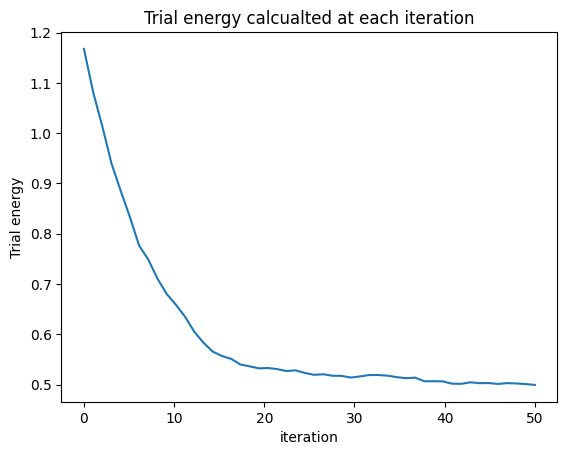

In [7]:
#Graphing algorithm's evolution in imaginary time
x = np.linspace(0, Energies.size, Energies.size)
plt.plot(x, Energies)
plt.xlabel('iteration')
plt.ylabel('Trial energy')
plt.title('Trial energy calcualted at each iteration')

Text(0.5, 1.0, 'Higher energy wavefunction contributions at each iteration')

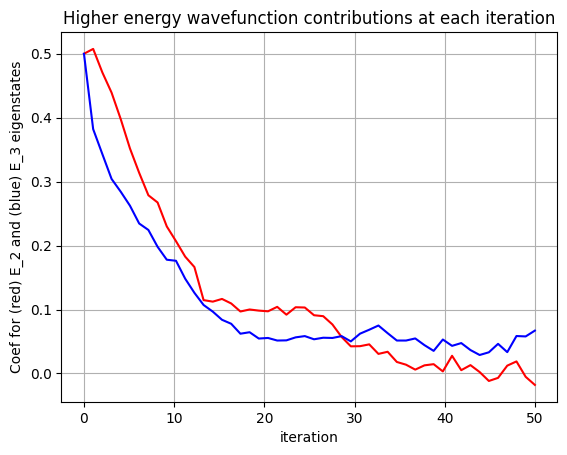

In [8]:
#Setting bs[0] and cs[0] to 0.5, as this is what they are in psi0
bs[0]=0.5
cs[0]=0.5
#Then plotting
plt.grid()
plt.plot(x, bs, color='r')
plt.plot(x, cs, color='b')
plt.xlabel('iteration')
plt.ylabel('Coef for (red) E_2 and (blue) E_3 eigenstates')
plt.title('Higher energy wavefunction contributions at each iteration')

The exponential decay into the ground state wave function with a trial energy approximately equal to the SHO ground state $E_0 = 0.5$ is exactly as we expect. Depending on the run, I've found I frequently get the blue line decaying faster than the red, which is not what we would expect considering it has a higher energy and therefore shorter timescale $\propto 1/(E_n-E_0)$. 